In [11]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import kornia.augmentation as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [12]:
BANDS = 100
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_BANDS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
data_dir = "C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot"
train_csv = pd.read_csv("C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/train.csv")
test_csv = pd.read_csv("C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/test.csv")

In [14]:
sample_file = os.path.join(data_dir, train_csv['id'][0])
sample_data = np.load(sample_file)

print(f"Shape of sample {train_csv['id'][0]}:", sample_data.shape)


Shape of sample sample697.npy: (128, 128, 125)


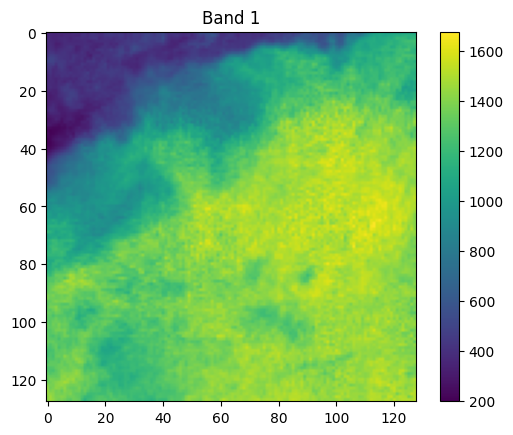

In [15]:
plt.imshow(sample_data[:, :, 0])
plt.title("Band 1")
plt.colorbar()
plt.show()


## Custom Dataset Loader

In [16]:
class HyperspectralDataset(Dataset):
    def __init__(self, df, base_path, patch_size=64, augment=False, num_bands=100):
        self.df = df
        self.base_path = base_path 
        self.patch_size = patch_size
        self.augment = augment
        self.num_bands = num_bands
        # Data augmentation
        self.transform = nn.Sequential( 
            K.RandomHorizontalFlip(p=0.3), # Randomly flip the image horizontally 
            K.RandomVerticalFlip(p=0.3),   # Randomly flip the image vertically
            K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.5), # Randomly apply affine transformation
            K.RandomCrop((patch_size, patch_size), padding=4, p=0.5)  # Randomly crop the image
        )
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.base_path}/{row['id']}" 

        try:
            img = np.load(img_path)

            if len(img.shape) == 2:
                img = np.repeat(img[:, :, np.newaxis], self.num_bands, axis=2)
            elif len(img.shape) == 3:
                if img.shape[2] > self.num_bands:
                    img = img[:, :, :self.num_bands]
                elif img.shape[2] < self.num_bands:
                    pad_width = ((0, 0), (0, 0), (0, self.num_bands - img.shape[2]))
                    img = np.pad(img, pad_width, mode='constant')

            img = img.astype(np.float32) / 65535.0  # Normalize image

            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to [C, H, W]

            if self.augment:
                img = self.transform(img.unsqueeze(0)).squeeze(0)

            if img.shape[1] != self.patch_size or img.shape[2] != self.patch_size:
                img = F.interpolate(img.unsqueeze(0), size=(self.patch_size, self.patch_size), mode='bilinear').squeeze(0)

            label = torch.tensor(row['label'], dtype=torch.long)  

            if label > 0:
                label = label - 1

            return img, label

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            dummy_img = torch.zeros(self.num_bands, self.patch_size, self.patch_size)
            dummy_label = torch.tensor(0, dtype=torch.long)  
            return dummy_img, dummy_label

In [17]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(concat))
        return x * attention


class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return out.view(b, c, 1, 1)

In [18]:
class HyperspectralCNN(nn.Module):
    def __init__(self, in_channels=NUM_BANDS, num_classes=100):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca2 = ChannelAttention(128)
        self.sa2 = SpatialAttention()
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, num_classes) 
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x
        
        x = self.conv2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x
        
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [19]:
def evaluate_model(model, loader, criterion, device = DEVICE):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item() * inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue
                
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if torch.isnan(outputs).any():
                continue
                
            loss = criterion(outputs.squeeze(), labels) 
            
            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
                valid_samples += inputs.size(0)
        
        if valid_samples > 0:
            train_loss /= valid_samples
            val_loss, val_preds, val_labels = evaluate_model(model, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            if len(val_preds.shape) == 2: 
                val_preds = np.argmax(val_preds, axis=1)
            
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"Sample predictions: {val_preds[:5]}, True labels: {val_labels[:5]}")
            
            
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), 'Spectrum_CNN.pth')
        else:
            print(f"Epoch {epoch+1}: No valid training samples")
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model

In [ ]:
def main():
    train_df = train_csv
    base_path = data_dir
    
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
    
    train_dataset = HyperspectralDataset(train_df, base_path, augment=True)
    val_dataset = HyperspectralDataset(val_df, base_path, augment=False)
    
    # Set num_workers=0 for debugging DataLoader issues
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = HyperspectralCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    model = train_model(model, train_loader, val_loader, EPOCHS, criterion, optimizer)
    
    model.load_state_dict(torch.load('Spectrum_CNN.pth'))
    
    return model

if __name__ == '__main__':
    model = main()